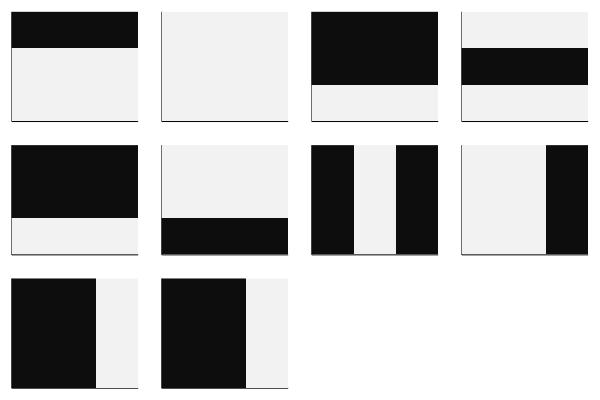

In [98]:
using Random
using Plots

n = 3
train = 10

#if repeats = false, need to find a way to not have duplicates
#check if train < 2^(n+1) - 2

function bars_and_stripes(train = 10, repeats = true) #Samples train data samples from the nxn bars_and_stripes synthetic dataset
    data = []
    for i in 1:train
        S = Int64[]
        while length(S) == 0 #Ensures length(S) is not 0 so we get truly uniform distribution over the whole bars and stripes dataset
            randsubseq!(S, collect(1:n), 0.5)
        end
        if 1 in S
            b = repeat(Bool[1], n)
        else
            b = repeat(Bool[0], n)
        end
        for i in 2:n
            temp = repeat(Bool[0], n)
            if i in S
                temp = repeat(Bool[1], n)
            end
            b = hcat(b, temp)
        end
        flip = rand() < 0.5
        if length(S) == n
            ret = flip ? b : .!b
        else
            ret = flip ? b : rotl90(b)
        end
        push!(data, ret)
    end
    return data
end

data_train = bars_and_stripes(train) #Stores data in data_train

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)

In [99]:
using Yao
using Flux

N = n^2 #Number of qubits

#Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) 
# Use CNN (because it's currently very bad at distinguishing images)
# Writing a discriminator in Pytorch is better?

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
#To enhance expressibility:
# Change circuit ansatz to include more generators
# Change pprior() to become nonconstant
# Gradient doesn't change if you sample from a nonconstant distribution of states? As opposed to all zero state
# Can prove this analytically
# Run on GPU?

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, :random)
dispatch!(g, rand(nparams).*2π)
println(parameters(g))

Number of parameters in discriminator: 111
Number of parameters in generator: 125
[2.086532310148101, 3.9433340802537287, 1.4396850307889035, 2.9487255485660246, 2.331287882731377, 2.8223795452811964, 2.629581913093383, 6.274499517873085, 3.6169252487990535, 1.105070652591307, 0.8193490260151123, 4.586421581192159, 1.2278063103330592, 4.3353135889758185, 3.6250114361188355, 2.2328865188542633, 2.178206197532205, 1.4546850768221435, 3.1133699048099293, 5.179600350128208, 5.619492958083747, 2.2864309934813845, 1.0504605300523462, 5.97370403532479, 5.5047044291980045, 2.891738549283793, 5.162611173069993, 2.8408165346442056, 1.1494858477892866, 4.427568815953275, 0.035174742372611936, 3.277973604978618, 4.91434147818624, 4.252491733255102, 0.6222722385088992, 3.5400228285714066, 1.5885858820163372, 5.201385161832245, 1.0253632340052692, 3.5208256170879144, 2.287466100757911, 6.274386559109985, 2.332587267214702, 6.2196542378488475, 4.328505681974874, 2.049504504041174, 1.6948994940832791,

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0]

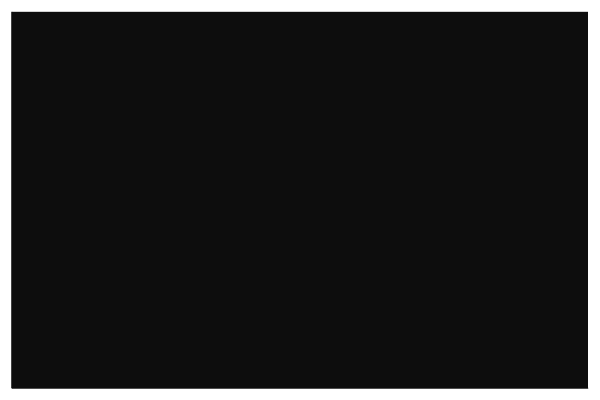

In [100]:
# using FLOYao
# using Random
# using Distributions

# mu = mean(trainstats)
# sigma = std(trainstats)
# println("μ: $mu")
# println("σ: $sigma")
# #dist = Normal(mu, sigma/20)
# dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0 #if ratio = 0 then pprior() is all 0s
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, n, n)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [101]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 100 #This doesn't need to be that big
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch)
    -mean(log.(run_d_fake(run_g(theta = theta, nbatch = nbatch))))
end

#Ideally... but how do u get gradients to go down? do we just not use flux train? tbh i'm ok with that but then i need to figure out how else to implement optimization stuff (maybe use python)
# function dLoss(nbatch = samplemean_batch)
#     real = mean(log.(run_d_real()))
#     fake = mean(log.(1 .- run_d_fake(run_g(nbatch))))
#     -(real + fake)
# end

#This is only formatted like this in order to use Flux.train!
#So maybe I shouldn't use it?
function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

function dLoss_actual(batch = train)
    real = []
    fake = []
    for m in 1:batch
        x = data_train[m] |> vec 
        push!(real, Int.(x))
        push!(fake, run_g(nbatch = 1)) #Find a better way to preprocess real and fake data...
    end
    data = collect(zip(real, fake)) 
    Flux.train!(dLoss, d, data, d_opt)
    s = 0
    for x in data
        s += dLoss(d, x[1], x[2])        
    end
    return s / batch
end

gLoss()

0.5811214f0

In [102]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss() #This is the problem
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

#println(finitediff_grad())
#Computing gradients is slow and also I'm still getting different results for parametershift and finitediff
#parametershift prints very small numbers and finitediff prints very big numbers...

# for _ in 1:10
#     println(parametershift_grad()) #Should print similar numbers...
# end

parametershift_grad (generic function with 2 methods)

In [103]:
g_lr = 1e-3

d_opt = Flux.setup(Adam(), d) 

gLoss_vals = []
dLoss_vals = []
mean_grads = []
dreal_vals = []
dfake_vals = []
g_params = []
d_params = []

# g_epochs = 20
# d_epochs = 1 #train until gLoss is higher than it was originally?
# g_threshold = 0.7
# d_threshold = 0.8
epochs = 500
batch = train

function trainG() #Does gradient descent on G, then saves its loss in gLoss_vals
    ∇ = parametershift_grad()
    push!(mean_grads, mean(∇))
    dispatch!(-, g, ∇ * g_lr)
    push!(gLoss_vals, gLoss())
end

function trainD() #Does one ADAM step on D, then saves its loss in _vals
    real = []
    fake = []
    for m in 1:batch
        x = data_train[m] |> vec 
        push!(real, Int.(x))
        push!(fake, run_g(nbatch = 1)) #Find a better way to preprocess real and fake data...
    end
    data = collect(zip(real, fake)) 
    Flux.train!(dLoss, d, data, d_opt)
    s = 0
    for x in data
        s += dLoss(d, x[1], x[2])        
    end
    push!(dLoss_vals, s / batch)
end

function saveParams()
    push!(g_params, parameters(g))
    push!(d_params, Flux.params(d))
end

g_init = gLoss()
push!(gLoss_vals, g_init)
d_init = dLoss_actual()
push!(dLoss_vals, d_init)

function g_threshold(b = g_init, i = 0)
    b - 0.1 - 0.01*i
end

function d_threshold(b = d_init, i = 0)
    b - 0.05 - 0.02*i
end

for i in 1:epochs
    t = time()
    j = 0
    g_init = gLoss()
    push!(gLoss_vals, g_init)
    #println("iteration $i g_threshold: ", g_threshold(g_init))
    while last(gLoss_vals) > g_threshold(g_init)
        j += 1
        trainG()
        if j % 10 == 0
            #println("g iteration $j", " loss: ", last(gLoss_vals))
        end
        if j > 50
            break
        end
    end
    println("g trained for $j")
    #println("g iteration $j", " loss: ", last(gLoss_vals))
    j = 0
    d_init = dLoss_actual()
    push!(dLoss_vals, d_init)
    #println("iteration $i d_threshold: ", d_threshold(d_init))
    while last(dLoss_vals) > d_threshold(d_init)
        j += 1
        trainD()
        if j % 10 == 0
            #println("d iteration $j", " loss: ", last(dLoss_vals))
        end
        if j > 10
            break
        end
    end
    println("d trained for $j")
    #println("d iteration $j", " loss: ", last(dLoss_vals))
    saveParams()
    # d_fake = first(run_d_fake(run_g(nbatch = 1))) #takes a fake data sample and runs d on it... but 
    # push!(dfake_vals, d_fake)
    # index = rand(1:train) #takes a random real data sample and runs d on it
    # d_real = data_train[index] |> vec |> d |> first 
    # push!(dreal_vals, d_real)
    println("iteration $i done in: ", time() - t)
end

g_epochs = 20
#last g_epochs of training for the generator, because we want g to be good, don't really care about d
for q in 1:g_epochs
    t = time()
    trainG()
    push!(g_params, parameters(g))
    println("iteration $q of additional training done in: ", time() - t)
end

g trained for 51
d trained for 2
iteration 1 done in: 97.20309710502625
g trained for 51


d trained for 1
iteration 2 done in: 97.28079009056091


g trained for 51
d trained for 1
iteration 3 done in: 96.91880989074707
g trained for 51


d trained for 1
iteration 4 done in: 97.66078615188599


g trained for 51
d trained for 7
iteration 5 done in: 96.90895509719849
g trained for 51


d trained for 3
iteration 6 done in: 96.27172589302063


g trained for 51
d trained for 1
iteration 7 done in: 97.01783919334412
g trained for 51


d trained for 11
iteration 8 done in: 96.7145140171051


g trained for 51
d trained for 3
iteration 9 done in: 97.49981498718262
g trained for 51


d trained for 2
iteration 10 done in: 96.87860298156738


g trained for 51
d trained for 8
iteration 11 done in: 95.6013650894165
g trained for 51


d trained for 11
iteration 12 done in: 96.09897994995117


g trained for 51
d trained for 5
iteration 13 done in: 95.53546380996704
g trained for 51


d trained for 8
iteration 14 done in: 95.21679496765137


g trained for 51
d trained for 8
iteration 15 done in: 95.4183840751648
g trained for 51


d trained for 1
iteration 16 done in: 95.26018691062927


g trained for 51
d trained for 1
iteration 17 done in: 95.33733201026917
g trained for 51


d trained for 11
iteration 18 done in: 95.01735997200012


g trained for 51
d trained for 11
iteration 19 done in: 95.7356538772583
g trained for 51


d trained for 11
iteration 20 done in: 94.9811110496521


g trained for 51
d trained for 11
iteration 21 done in: 95.22788906097412
g trained for 14


d trained for 1
iteration 22 done in: 26.091328144073486


g trained for 51
d trained for 3
iteration 23 done in: 95.66588711738586
g trained for 51


d trained for 11
iteration 24 done in: 95.30645108222961


g trained for 27
d trained for 1
iteration 25 done in: 50.55856513977051
g trained for 3


d trained for 1
iteration 26 done in: 5.557809829711914


g trained for 4
d trained for 1
iteration 27 done in: 7.850642204284668
g trained for 13


d trained for 1
iteration 28 done in: 24.173398971557617


g trained for 3
d trained for 1
iteration 29 done in: 5.598005056381226
g trained for 51


d trained for 2
iteration 30 done in: 95.60290503501892


g trained for 51
d trained for 2
iteration 31 done in: 95.29093408584595
g trained for 1


d trained for 3
iteration 32 done in: 1.859724998474121


g trained for 49
d trained for 1
iteration 33 done in: 91.75834202766418
g trained for 3


d trained for 2
iteration 34 done in: 5.591285943984985


g trained for 27
d trained for 1
iteration 35 done in: 51.89528203010559
g trained for 51


d trained for 4
iteration 36 done in: 95.56055498123169


g trained for 5
d trained for 11
iteration 37 done in: 9.316879987716675
g trained for 23


d trained for 1
iteration 38 done in: 42.80149006843567


g trained for 8
d trained for 10
iteration 39 done in: 14.809767007827759
g trained for 8


d trained for 8
iteration 40 done in: 15.073462963104248


g trained for 51
d trained for 3
iteration 41 done in: 95.12927508354187
g trained for 51


d trained for 5
iteration 42 done in: 95.98237895965576


g trained for 51
d trained for 1
iteration 43 done in: 94.92019295692444
g trained for 14


d trained for 8
iteration 44 done in: 26.210028886795044


g trained for 1
d trained for 11
iteration 45 done in: 1.8781211376190186
g trained for 9


d trained for 2
iteration 46 done in: 17.081580877304077


g trained for 21
d trained for 7
iteration 47 done in: 39.71219491958618
g trained for 3


d trained for 3
iteration 48 done in: 5.612356901168823


g trained for 26
d trained for 2
iteration 49 done in: 48.50320601463318
g trained for 3


d trained for 2
iteration 50 done in: 5.545568943023682


g trained for 20
d trained for 9
iteration 51 done in: 37.70785593986511
g trained for 37


d trained for 1
iteration 52 done in: 69.4089469909668


g trained for 2
d trained for 1
iteration 53 done in: 3.782794952392578
g trained for 1


d trained for 4
iteration 54 done in: 1.877511978149414


g trained for 6
d trained for 1
iteration 55 done in: 11.116857051849365
g trained for 6


d trained for 1
iteration 56 done in: 11.178023099899292


g trained for 51
d trained for 2
iteration 57 done in: 95.49940705299377
g trained for 2


d trained for 3
iteration 58 done in: 3.7225000858306885


g trained for 51
d trained for 11
iteration 59 done in: 95.21775102615356
g trained for 12


d trained for 5
iteration 60 done in: 22.625013828277588


g trained for 51
d trained for 3
iteration 61 done in: 95.32963418960571
g trained for 8


d trained for 1
iteration 62 done in: 15.212772130966187


g trained for 29
d trained for 4
iteration 63 done in: 54.29657483100891
g trained for 41


d trained for 3
iteration 64 done in: 77.05399918556213


g trained for 48
d trained for 1
iteration 65 done in: 90.10596799850464
g trained for 2


d trained for 1
iteration 66 done in: 3.7777469158172607


g trained for 4
d trained for 6
iteration 67 done in: 7.476499080657959
g trained for 4


d trained for 1
iteration 68 done in: 8.094008922576904


g trained for 50
d trained for 10
iteration 69 done in: 93.73518204689026
g trained for 6


d trained for 6
iteration 70 done in: 11.17121410369873


g trained for 2
d trained for 1
iteration 71 done in: 3.7299699783325195
g trained for 3


d trained for 3
iteration 72 done in: 5.942623138427734


g trained for 2
d trained for 1
iteration 73 done in: 3.752044916152954
g trained for 11


d trained for 1
iteration 74 done in: 20.44423198699951


g trained for 1
d trained for 4
iteration 75 done in: 1.8633780479431152
g trained for 8


d trained for 1
iteration 76 done in: 14.893426895141602


g trained for 29
d trained for 10
iteration 77 done in: 54.276285886764526
g trained for 12


d trained for 1
iteration 78 done in: 22.772515058517456


g trained for 51
d trained for 1
iteration 79 done in: 95.55734610557556
g trained for 30


d trained for 6
iteration 80 done in: 56.28878092765808


g trained for 51
d trained for 1
iteration 81 done in: 96.18645191192627
g trained for 1


d trained for 11
iteration 82 done in: 1.9881889820098877


g trained for 1
d trained for 3
iteration 83 done in: 1.9444591999053955
g trained for 11


d trained for 1
iteration 84 done in: 20.560265064239502


g trained for 4
d trained for 1
iteration 85 done in: 7.578918933868408
g trained for 4


d trained for 11
iteration 86 done in: 7.5214221477508545


g trained for 22
d trained for 1
iteration 87 done in: 41.64159893989563
g trained for 14


d trained for 3
iteration 88 done in: 26.24579095840454


g trained for 51
d trained for 1
iteration 89 done in: 96.43565487861633
g trained for 6


d trained for 11
iteration 90 done in: 11.228775978088379


g trained for 46
d trained for 1
iteration 91 done in: 86.4623510837555
g trained for 10


d trained for 5
iteration 92 done in: 18.7954740524292


g trained for 31
d trained for 11
iteration 93 done in: 58.377650022506714
g trained for 2


d trained for 8
iteration 94 done in: 3.7442209720611572


g trained for 12
d trained for 1
iteration 95 done in: 22.2969810962677
g trained for 51


d trained for 1
iteration 96 done in: 95.79573917388916


g trained for 12
d trained for 8
iteration 97 done in: 22.524499893188477
g trained for 6


d trained for 8
iteration 98 done in: 11.65717601776123


g trained for 5
d trained for 1
iteration 99 done in: 9.340540885925293
g trained for 2


d trained for 11
iteration 100 done in: 3.7832491397857666


g trained for 1
d trained for 11
iteration 101 done in: 1.8803188800811768
g trained for 15


d trained for 3
iteration 102 done in: 28.059945821762085


g trained for 1
d trained for 1
iteration 103 done in: 1.8749151229858398
g trained for 3


d trained for 11
iteration 104 done in: 5.589489936828613


g trained for 26
d trained for 1
iteration 105 done in: 48.96009397506714
g trained for 2


d trained for 1
iteration 106 done in: 3.73836088180542


g trained for 2
d trained for 2
iteration 107 done in: 3.735980987548828
g trained for 45


d trained for 1
iteration 108 done in: 84.42453694343567


g trained for 1
d trained for 1
iteration 109 done in: 1.9418060779571533
g trained for 1


d trained for 1
iteration 110 done in: 1.8776428699493408


g trained for 51
d trained for 11
iteration 111 done in: 95.96112489700317
g trained for 51


d trained for 3
iteration 112 done in: 95.71863889694214


g trained for 1
d trained for 1
iteration 113 done in: 1.9199960231781006
g trained for 4


d trained for 1
iteration 114 done in: 7.577548980712891


g trained for 18
d trained for 1
iteration 115 done in: 33.93427395820618
g trained for 7


d trained for 1
iteration 116 done in: 13.280288219451904


g trained for 31
d trained for 11
iteration 117 done in: 58.5014910697937
g trained for 1


d trained for 1
iteration 118 done in: 1.8907229900360107


g trained for 2
d trained for 11
iteration 119 done in: 3.7630600929260254
g trained for 13


d trained for 1
iteration 120 done in: 24.51371693611145


g trained for 4
d trained for 1
iteration 121 done in: 7.867866039276123
g trained for 1


d trained for 3
iteration 122 done in: 1.8809430599212646


g trained for 1
d trained for 11
iteration 123 done in: 1.88441801071167
g trained for 1


d trained for 6
iteration 124 done in: 1.9127569198608398


g trained for 4
d trained for 3
iteration 125 done in: 7.484867811203003
g trained for 15


d trained for 2
iteration 126 done in: 27.918370008468628


g trained for 1
d trained for 1
iteration 127 done in: 1.8543150424957275
g trained for 3


d trained for 2
iteration 128 done in: 5.99140191078186


g trained for 1
d trained for 1
iteration 129 done in: 1.8852269649505615
g trained for 2


d trained for 3
iteration 130 done in: 3.737990140914917


g trained for 1
d trained for 2
iteration 131 done in: 1.8722550868988037
g trained for 2


d trained for 11
iteration 132 done in: 4.121287107467651


g trained for 20
d trained for 11
iteration 133 done in: 37.20174193382263
g trained for 3


d trained for 11
iteration 134 done in: 5.619658946990967


g trained for 3
d trained for 2
iteration 135 done in: 5.700390100479126
g trained for 12


d trained for 2
iteration 136 done in: 22.534414052963257


g trained for 4
d trained for 1
iteration 137 done in: 7.447965145111084
g trained for 4


d trained for 11
iteration 138 done in: 7.543368101119995


g trained for 1
d trained for 7
iteration 139 done in: 1.8949549198150635
g trained for 51


d trained for 2
iteration 140 done in: 95.45954704284668


g trained for 10
d trained for 1
iteration 141 done in: 18.823139905929565
g trained for 10


d trained for 5
iteration 142 done in: 18.901777982711792


g trained for 10
d trained for 11
iteration 143 done in: 19.072454929351807
g trained for 8


d trained for 1
iteration 144 done in: 14.88388180732727


g trained for 1
d trained for 1
iteration 145 done in: 1.860733985900879
g trained for 18


d trained for 3
iteration 146 done in: 33.761735916137695


g trained for 2
d trained for 2
iteration 147 done in: 3.7685909271240234
g trained for 4


d trained for 1
iteration 148 done in: 7.637631893157959


g trained for 30
d trained for 1
iteration 149 done in: 56.125335931777954
g trained for 12


d trained for 11
iteration 150 done in: 22.584967851638794


g trained for 1
d trained for 1
iteration 151 done in: 1.8784830570220947
g trained for 1


d trained for 11
iteration 152 done in: 1.866832971572876


g trained for 1
d trained for 1
iteration 153 done in: 1.882840871810913
g trained for 12


d trained for 10
iteration 154 done in: 22.43973422050476


g trained for 46
d trained for 11
iteration 155 done in: 86.15864610671997
g trained for 1


d trained for 11
iteration 156 done in: 1.8934440612792969


g trained for 9
d trained for 11
iteration 157 done in: 16.820391178131104
g trained for 51


d trained for 1
iteration 158 done in: 96.02609395980835


g trained for 36
d trained for 1
iteration 159 done in: 68.25187087059021
g trained for 14


d trained for 11
iteration 160 done in: 26.482177019119263


g trained for 1
d trained for 11
iteration 161 done in: 1.879202127456665
g trained for 1


d trained for 9
iteration 162 done in: 1.9030699729919434


g trained for 1
d trained for 3
iteration 163 done in: 1.8588511943817139
g trained for 2


d trained for 11
iteration 164 done in: 3.8241360187530518


g trained for 1
d trained for 11
iteration 165 done in: 1.901663064956665
g trained for 1


d trained for 3
iteration 166 done in: 2.1458449363708496


g trained for 1
d trained for 4
iteration 167 done in: 1.897385835647583
g trained for 6


d trained for 3
iteration 168 done in: 11.206133842468262


g trained for 1
d trained for 2
iteration 169 done in: 1.8814411163330078
g trained for 3


d trained for 11
iteration 170 done in: 5.6494598388671875


g trained for 2
d trained for 8
iteration 171 done in: 3.7167601585388184
g trained for 2


d trained for 1
iteration 172 done in: 3.855822801589966


g trained for 1
d trained for 6
iteration 173 done in: 2.026750087738037
g trained for 1


d trained for 9
iteration 174 done in: 1.8933348655700684


g trained for 3
d trained for 1
iteration 175 done in: 5.649845838546753
g trained for 1


d trained for 11
iteration 176 done in: 1.8949341773986816


g trained for 2
d trained for 1
iteration 177 done in: 3.721389055252075
g trained for 1


d trained for 1
iteration 178 done in: 1.8802919387817383


g trained for 1
d trained for 2
iteration 179 done in: 1.8867530822753906
g trained for 1


d trained for 1
iteration 180 done in: 1.861208200454712


g trained for 33
d trained for 2
iteration 181 done in: 62.13879990577698
g trained for 1


d trained for 3
iteration 182 done in: 1.8743658065795898


g trained for 2
d trained for 11
iteration 183 done in: 3.743191957473755
g trained for 1


d trained for 3
iteration 184 done in: 1.879162073135376


g trained for 1
d trained for 1
iteration 185 done in: 2.1500778198242188
g trained for 5


d trained for 1
iteration 186 done in: 9.304996967315674


g trained for 51
d trained for 1
iteration 187 done in: 96.08097887039185
g trained for 22


d trained for 1
iteration 188 done in: 41.237215995788574


g trained for 2
d trained for 11
iteration 189 done in: 3.7602858543395996
g trained for 7


d trained for 2
iteration 190 done in: 13.252461910247803


g trained for 4
d trained for 11
iteration 191 done in: 7.525831937789917
g trained for 1


d trained for 1
iteration 192 done in: 1.8799090385437012


g trained for 1
d trained for 1
iteration 193 done in: 1.8956389427185059
g trained for 51


d trained for 1
iteration 194 done in: 95.920814037323


g trained for 15
d trained for 3
iteration 195 done in: 28.305586099624634
g trained for 2


d trained for 1
iteration 196 done in: 3.810896873474121


g trained for 1
d trained for 4
iteration 197 done in: 1.9103219509124756
g trained for 1


d trained for 11
iteration 198 done in: 1.897994041442871


g trained for 2
d trained for 1
iteration 199 done in: 3.703951835632324
g trained for 40


d trained for 1
iteration 200 done in: 74.94086194038391


g trained for 4
d trained for 2
iteration 201 done in: 7.597398042678833
g trained for 8


d trained for 11
iteration 202 done in: 14.933640956878662


g trained for 4
d trained for 1
iteration 203 done in: 7.540295124053955
g trained for 3


d trained for 11
iteration 204 done in: 5.867067098617554


g trained for 1
d trained for 11
iteration 205 done in: 1.9187889099121094
g trained for 1


d trained for 11
iteration 206 done in: 1.8876440525054932


g trained for 2
d trained for 1
iteration 207 done in: 3.7396111488342285
g trained for 2


d trained for 1
iteration 208 done in: 3.780369997024536


g trained for 1
d trained for 10
iteration 209 done in: 1.896139144897461
g trained for 2


d trained for 2
iteration 210 done in: 3.720134973526001


g trained for 5
d trained for 11
iteration 211 done in: 9.311333179473877
g trained for 1


d trained for 7
iteration 212 done in: 1.8791639804840088


g trained for 1
d trained for 1
iteration 213 done in: 1.8870718479156494
g trained for 14


d trained for 1
iteration 214 done in: 26.152827978134155


g trained for 25
d trained for 11
iteration 215 done in: 47.25009608268738
g trained for 2


d trained for 2
iteration 216 done in: 3.8575661182403564


g trained for 6
d trained for 11
iteration 217 done in: 11.368342161178589
g trained for 2


d trained for 2
iteration 218 done in: 3.759484052658081


g trained for 1
d trained for 11
iteration 219 done in: 1.9286270141601562
g trained for 2


d trained for 11
iteration 220 done in: 3.783061981201172


g trained for 1
d trained for 11
iteration 221 done in: 1.8854200839996338
g trained for 1


d trained for 11
iteration 222 done in: 1.9283430576324463


g trained for 1
d trained for 9
iteration 223 done in: 1.8893060684204102
g trained for 2


d trained for 7
iteration 224 done in: 3.7777390480041504


g trained for 1
d trained for 9
iteration 225 done in: 1.883815050125122
g trained for 1


d trained for 1
iteration 226 done in: 1.8711490631103516


g trained for 1
d trained for 11
iteration 227 done in: 1.8775300979614258
g trained for 1


d trained for 1
iteration 228 done in: 1.9056429862976074


g trained for 1
d trained for 1
iteration 229 done in: 1.8672301769256592
g trained for 31


d trained for 4
iteration 230 done in: 58.069803953170776


g trained for 1
d trained for 3
iteration 231 done in: 1.8802528381347656
g trained for 1


d trained for 5
iteration 232 done in: 1.9197089672088623


g trained for 51
d trained for 2
iteration 233 done in: 95.74572420120239
g trained for 1


d trained for 10
iteration 234 done in: 1.8813450336456299


g trained for 3
d trained for 3
iteration 235 done in: 5.596670150756836
g trained for 1


d trained for 3
iteration 236 done in: 1.9055778980255127


g trained for 16
d trained for 1
iteration 237 done in: 30.0112361907959
g trained for 5


d trained for 2
iteration 238 done in: 9.363301038742065


g trained for 1
d trained for 11
iteration 239 done in: 1.911776065826416
g trained for 1


d trained for 1
iteration 240 done in: 1.8911609649658203


g trained for 1
d trained for 11
iteration 241 done in: 2.07765793800354
g trained for 18


d trained for 1
iteration 242 done in: 33.66606783866882


g trained for 1
d trained for 11
iteration 243 done in: 1.885693073272705
g trained for 22


d trained for 6
iteration 244 done in: 41.38608694076538


g trained for 4
d trained for 11
iteration 245 done in: 7.5063910484313965
g trained for 5


d trained for 11
iteration 246 done in: 9.483701944351196


g trained for 1
d trained for 1
iteration 247 done in: 1.8807950019836426
g trained for 1


d trained for 1
iteration 248 done in: 1.8957459926605225


g trained for 4
d trained for 2
iteration 249 done in: 7.5549890995025635
g trained for 1


d trained for 3
iteration 250 done in: 1.8959689140319824


g trained for 1
d trained for 1
iteration 251 done in: 1.8687958717346191
g trained for 14


d trained for 5
iteration 252 done in: 26.286582946777344


g trained for 3
d trained for 1
iteration 253 done in: 5.59319806098938
g trained for 7


d trained for 3
iteration 254 done in: 13.23912501335144


g trained for 51
d trained for 1
iteration 255 done in: 96.01189589500427
g trained for 51


d trained for 4
iteration 256 done in: 95.87845396995544


g trained for 12
d trained for 1
iteration 257 done in: 22.890196084976196
g trained for 2


d trained for 8
iteration 258 done in: 3.818145990371704


g trained for 1
d trained for 1
iteration 259 done in: 1.9102368354797363
g trained for 1


d trained for 1
iteration 260 done in: 1.8853089809417725


g trained for 2
d trained for 1
iteration 261 done in: 3.7490649223327637
g trained for 1


d trained for 11
iteration 262 done in: 1.877251148223877


g trained for 8
d trained for 4
iteration 263 done in: 15.091269969940186
g trained for 1


d trained for 2
iteration 264 done in: 1.8879330158233643


g trained for 1
d trained for 8
iteration 265 done in: 1.876859188079834
g trained for 29


d trained for 10
iteration 266 done in: 54.65498995780945


g trained for 51
d trained for 3
iteration 267 done in: 95.65311598777771
g trained for 2


d trained for 11
iteration 268 done in: 3.7787342071533203


g trained for 14
d trained for 7
iteration 269 done in: 26.2295241355896
g trained for 40


d trained for 1
iteration 270 done in: 74.95009303092957


g trained for 3
d trained for 1
iteration 271 done in: 5.814175128936768
g trained for 2


d trained for 11
iteration 272 done in: 3.7676708698272705


g trained for 1
d trained for 11
iteration 273 done in: 1.9252228736877441
g trained for 1


d trained for 3
iteration 274 done in: 1.8849129676818848


g trained for 3
d trained for 1
iteration 275 done in: 5.600068092346191
g trained for 1


d trained for 11
iteration 276 done in: 1.884592056274414


g trained for 51
d trained for 7
iteration 277 done in: 95.94722604751587
g trained for 15


d trained for 8
iteration 278 done in: 28.59709405899048


g trained for 1
d trained for 5
iteration 279 done in: 1.8899469375610352
g trained for 5


d trained for 1
iteration 280 done in: 9.373541116714478


g trained for 1
d trained for 1
iteration 281 done in: 1.9236609935760498
g trained for 7


d trained for 11
iteration 282 done in: 13.10519003868103


g trained for 7
d trained for 1
iteration 283 done in: 13.692511081695557
g trained for 32


d trained for 3
iteration 284 done in: 60.67089796066284


g trained for 5
d trained for 11
iteration 285 done in: 9.474092960357666
g trained for 44


d trained for 11
iteration 286 done in: 82.66476392745972


g trained for 2
d trained for 11
iteration 287 done in: 3.7558279037475586
g trained for 3


d trained for 4
iteration 288 done in: 5.6007678508758545


g trained for 1
d trained for 2
iteration 289 done in: 1.8833510875701904
g trained for 4


d trained for 1
iteration 290 done in: 7.445960998535156


g trained for 1
d trained for 3
iteration 291 done in: 1.9110682010650635
g trained for 51


d trained for 11
iteration 292 done in: 95.8844850063324


g trained for 2
d trained for 1
iteration 293 done in: 3.7753231525421143
g trained for 1


d trained for 11
iteration 294 done in: 1.8851640224456787


g trained for 2
d trained for 7
iteration 295 done in: 3.771193027496338
g trained for 1


d trained for 8
iteration 296 done in: 1.8747639656066895


g trained for 1
d trained for 1
iteration 297 done in: 1.8548359870910645
g trained for 9


d trained for 2
iteration 298 done in: 17.038419008255005


g trained for 1
d trained for 1
iteration 299 done in: 1.8870739936828613
g trained for 4


d trained for 1
iteration 300 done in: 7.465435981750488


g trained for 2
d trained for 1
iteration 301 done in: 3.769439935684204
g trained for 3


d trained for 11
iteration 302 done in: 5.646728992462158


g trained for 1
d trained for 1
iteration 303 done in: 1.902730941772461
g trained for 9


d trained for 11
iteration 304 done in: 16.870543003082275


g trained for 3
d trained for 11
iteration 305 done in: 5.6719958782196045
g trained for 2


d trained for 2
iteration 306 done in: 3.758409023284912


g trained for 1
d trained for 11
iteration 307 done in: 1.907500982284546
g trained for 3


d trained for 11
iteration 308 done in: 5.69041895866394


g trained for 5
d trained for 11
iteration 309 done in: 9.601348876953125
g trained for 1


d trained for 3
iteration 310 done in: 1.8701848983764648


g trained for 1
d trained for 1
iteration 311 done in: 1.8801469802856445
g trained for 45


d trained for 11
iteration 312 done in: 84.3272750377655


g trained for 1
d trained for 9
iteration 313 done in: 1.906451940536499
g trained for 4


d trained for 4
iteration 314 done in: 7.484685182571411


g trained for 6
d trained for 11
iteration 315 done in: 11.21682095527649
g trained for 1


d trained for 2
iteration 316 done in: 1.9847228527069092


g trained for 6
d trained for 11
iteration 317 done in: 11.47459101676941
g trained for 1


d trained for 11
iteration 318 done in: 1.9022619724273682


g trained for 4
d trained for 5
iteration 319 done in: 7.481966972351074
g trained for 1


d trained for 5
iteration 320 done in: 1.8941011428833008


g trained for 49
d trained for 1
iteration 321 done in: 92.00362396240234
g trained for 15


d trained for 2
iteration 322 done in: 28.19521403312683


g trained for 1
d trained for 11
iteration 323 done in: 1.9031541347503662
g trained for 25


d trained for 3
iteration 324 done in: 47.13458204269409


g trained for 6
d trained for 4
iteration 325 done in: 11.238282918930054
g trained for 1


d trained for 2
iteration 326 done in: 1.8868770599365234


g trained for 7
d trained for 1
iteration 327 done in: 13.086405992507935
g trained for 11


d trained for 11
iteration 328 done in: 20.682558059692383


g trained for 1
d trained for 11
iteration 329 done in: 1.9040770530700684
g trained for 3


d trained for 2
iteration 330 done in: 5.77753210067749


g trained for 21
d trained for 1
iteration 331 done in: 39.250081062316895
g trained for 2


d trained for 8
iteration 332 done in: 3.798696994781494


g trained for 4
d trained for 11
iteration 333 done in: 7.497493028640747
g trained for 1


d trained for 1
iteration 334 done in: 1.8760781288146973


g trained for 1
d trained for 1
iteration 335 done in: 1.9040348529815674
g trained for 3


d trained for 1
iteration 336 done in: 5.7178380489349365


g trained for 3
d trained for 11
iteration 337 done in: 5.673708200454712
g trained for 8


d trained for 1
iteration 338 done in: 14.91940188407898


g trained for 1
d trained for 8
iteration 339 done in: 1.9167320728302002
g trained for 4


d trained for 1
iteration 340 done in: 7.556309938430786


g trained for 1
d trained for 7
iteration 341 done in: 1.9471969604492188
g trained for 11


d trained for 11
iteration 342 done in: 20.63046097755432


g trained for 1
d trained for 1
iteration 343 done in: 1.9254660606384277
g trained for 6


d trained for 11
iteration 344 done in: 11.421593189239502


g trained for 2
d trained for 1
iteration 345 done in: 3.7508978843688965
g trained for 3


d trained for 1
iteration 346 done in: 5.657196044921875


g trained for 2
d trained for 1
iteration 347 done in: 3.802769184112549
g trained for 2


d trained for 11
iteration 348 done in: 3.762415885925293


g trained for 11
d trained for 8
iteration 349 done in: 20.54837203025818
g trained for 1


d trained for 11
iteration 350 done in: 1.9370591640472412


g trained for 1
d trained for 1
iteration 351 done in: 1.930866003036499
g trained for 1


d trained for 1
iteration 352 done in: 1.8783819675445557


g trained for 4
d trained for 1
iteration 353 done in: 7.65132999420166
g trained for 7


d trained for 11
iteration 354 done in: 13.09811806678772


g trained for 1
d trained for 11
iteration 355 done in: 1.9093661308288574
g trained for 45


d trained for 1
iteration 356 done in: 84.74502992630005


g trained for 15
d trained for 11
iteration 357 done in: 28.286455869674683
g trained for 50


d trained for 4
iteration 358 done in: 94.02924799919128


g trained for 1
d trained for 1
iteration 359 done in: 1.8975651264190674
g trained for 2


d trained for 5
iteration 360 done in: 3.73693585395813


g trained for 8
d trained for 11
iteration 361 done in: 15.322135925292969
g trained for 4


d trained for 7
iteration 362 done in: 7.531903028488159


g trained for 1
d trained for 11
iteration 363 done in: 1.9260070323944092
g trained for 7


d trained for 11
iteration 364 done in: 13.137928009033203


g trained for 2
d trained for 11
iteration 365 done in: 3.8000481128692627
g trained for 14


d trained for 1
iteration 366 done in: 26.126533031463623


g trained for 1
d trained for 11
iteration 367 done in: 1.8816139698028564
g trained for 1


d trained for 2
iteration 368 done in: 2.0301759243011475


g trained for 22
d trained for 2
iteration 369 done in: 41.18401312828064
g trained for 1


d trained for 1
iteration 370 done in: 1.9121348857879639


g trained for 1
d trained for 11
iteration 371 done in: 1.8847050666809082
g trained for 2


d trained for 11
iteration 372 done in: 3.781370162963867


g trained for 3
d trained for 11
iteration 373 done in: 5.650893926620483
g trained for 3


d trained for 11
iteration 374 done in: 6.037262916564941


g trained for 9
d trained for 7
iteration 375 done in: 16.906508922576904
g trained for 1


d trained for 1
iteration 376 done in: 1.918220043182373


g trained for 1
d trained for 11
iteration 377 done in: 1.9115488529205322
g trained for 5


d trained for 11
iteration 378 done in: 9.360234022140503


g trained for 4
d trained for 11
iteration 379 done in: 7.493458986282349
g trained for 5


d trained for 11
iteration 380 done in: 9.3851318359375


g trained for 3
d trained for 2
iteration 381 done in: 5.586507081985474
g trained for 22


d trained for 1
iteration 382 done in: 41.891453981399536


g trained for 1
d trained for 4
iteration 383 done in: 1.9431788921356201
g trained for 51


d trained for 9
iteration 384 done in: 95.79401803016663


g trained for 1
d trained for 6
iteration 385 done in: 1.9066951274871826
g trained for 2


d trained for 11
iteration 386 done in: 3.765704870223999


g trained for 1
d trained for 2
iteration 387 done in: 1.8908541202545166
g trained for 3


d trained for 11
iteration 388 done in: 5.658423900604248


g trained for 4
d trained for 11
iteration 389 done in: 7.5091588497161865
g trained for 1


d trained for 1
iteration 390 done in: 1.9732420444488525


g trained for 1
d trained for 5
iteration 391 done in: 1.913815975189209
g trained for 2


d trained for 10
iteration 392 done in: 3.7655129432678223


g trained for 4
d trained for 11
iteration 393 done in: 7.508452892303467
g trained for 11


d trained for 4
iteration 394 done in: 20.775567054748535


g trained for 2
d trained for 8
iteration 395 done in: 3.753480911254883
g trained for 1


d trained for 11
iteration 396 done in: 1.8802218437194824


g trained for 7
d trained for 2
iteration 397 done in: 13.200167894363403
g trained for 1


d trained for 3
iteration 398 done in: 1.9304580688476562


g trained for 2
d trained for 4
iteration 399 done in: 3.7514050006866455
g trained for 2


d trained for 1
iteration 400 done in: 3.802804946899414


g trained for 4
d trained for 11
iteration 401 done in: 7.502992153167725
g trained for 5


d trained for 1
iteration 402 done in: 9.361526012420654


g trained for 1
d trained for 11
iteration 403 done in: 1.9297559261322021
g trained for 1


d trained for 11
iteration 404 done in: 1.8924438953399658


g trained for 10
d trained for 11
iteration 405 done in: 18.935396909713745
g trained for 1


d trained for 2
iteration 406 done in: 1.8724160194396973


g trained for 32
d trained for 11
iteration 407 done in: 60.509002923965454
g trained for 3


d trained for 1
iteration 408 done in: 5.646328926086426


g trained for 51
d trained for 11
iteration 409 done in: 96.00873899459839
g trained for 6


d trained for 11
iteration 410 done in: 11.30148696899414


g trained for 4
d trained for 11
iteration 411 done in: 7.456968069076538
g trained for 10


d trained for 11
iteration 412 done in: 19.068015813827515


g trained for 9
d trained for 11
iteration 413 done in: 16.965879917144775
g trained for 1


d trained for 11
iteration 414 done in: 1.9217228889465332


g trained for 2
d trained for 4
iteration 415 done in: 4.372376918792725
g trained for 2


d trained for 11
iteration 416 done in: 3.992717981338501


g trained for 14
d trained for 3
iteration 417 done in: 26.540791034698486
g trained for 35


d trained for 11
iteration 418 done in: 66.11046004295349


g trained for 11
d trained for 1
iteration 419 done in: 20.86401391029358
g trained for 1


d trained for 11
iteration 420 done in: 1.9189200401306152


g trained for 51
d trained for 11
iteration 421 done in: 95.80715489387512
g trained for 2


d trained for 11
iteration 422 done in: 3.7570879459381104


g trained for 9
d trained for 11
iteration 423 done in: 16.9545841217041
g trained for 2


d trained for 11
iteration 424 done in: 3.9422459602355957


g trained for 2
d trained for 1
iteration 425 done in: 3.795790195465088
g trained for 23


d trained for 1
iteration 426 done in: 43.12922501564026


g trained for 1
d trained for 11
iteration 427 done in: 1.9083058834075928
g trained for 33


d trained for 1
iteration 428 done in: 62.417155027389526


g trained for 2
d trained for 11
iteration 429 done in: 3.9013619422912598
g trained for 3


d trained for 11
iteration 430 done in: 6.084813117980957


g trained for 5
d trained for 11
iteration 431 done in: 9.542952060699463
g trained for 1


d trained for 11
iteration 432 done in: 1.9757530689239502


g trained for 3
d trained for 11
iteration 433 done in: 5.738790035247803
g trained for 16


d trained for 11
iteration 434 done in: 30.26556396484375


g trained for 7
d trained for 11
iteration 435 done in: 13.750046014785767
g trained for 51


d trained for 11
iteration 436 done in: 97.29605293273926


g trained for 3
d trained for 11
iteration 437 done in: 5.681181907653809
g trained for 7


d trained for 11
iteration 438 done in: 13.454550981521606


g trained for 51
d trained for 11
iteration 439 done in: 96.89322805404663
g trained for 3


d trained for 11
iteration 440 done in: 5.727482080459595


g trained for 51
d trained for 11
iteration 441 done in: 97.24408292770386
g trained for 48


d trained for 11
iteration 442 done in: 90.42504811286926


g trained for 51
d trained for 11
iteration 443 done in: 96.2883369922638
g trained for 6


d trained for 11
iteration 444 done in: 11.370195150375366


g trained for 3
d trained for 11
iteration 445 done in: 5.668748140335083
g trained for 51


d trained for 11
iteration 446 done in: 96.65590691566467


g trained for 45
d trained for 11
iteration 447 done in: 84.72742104530334
g trained for 18


d trained for 11
iteration 448 done in: 34.25586795806885


g trained for 51
d trained for 11
iteration 449 done in: 96.72051811218262
g trained for 24


d trained for 11
iteration 450 done in: 45.72614598274231


g trained for 51
d trained for 11
iteration 451 done in: 96.26816296577454
g trained for 51


d trained for 11
iteration 452 done in: 95.96508598327637


g trained for 51
d trained for 11
iteration 453 done in: 96.63085103034973
g trained for 42


d trained for 11
iteration 454 done in: 79.08915209770203


g trained for 11
d trained for 11
iteration 455 done in: 21.003900051116943
g trained for 51


d trained for 11
iteration 456 done in: 96.47184109687805


g trained for 44
d trained for 11
iteration 457 done in: 84.0652220249176
g trained for 1


d trained for 11
iteration 458 done in: 1.9579799175262451


g trained for 1
d trained for 1
iteration 459 done in: 1.878371000289917
g trained for 1


d trained for 11
iteration 460 done in: 1.8933641910552979


g trained for 51
d trained for 11
iteration 461 done in: 96.1394829750061
g trained for 51


d trained for 11
iteration 462 done in: 96.251708984375


g trained for 51
d trained for 11
iteration 463 done in: 96.18949890136719
g trained for 51


d trained for 11
iteration 464 done in: 96.20552396774292


g trained for 1
d trained for 11
iteration 465 done in: 1.9064068794250488
g trained for 51


d trained for 11
iteration 466 done in: 95.9654381275177


g trained for 32
d trained for 11
iteration 467 done in: 60.22868800163269
g trained for 15


d trained for 11
iteration 468 done in: 28.163381099700928


g trained for 51
d trained for 11
iteration 469 done in: 96.19884896278381
g trained for 11


d trained for 11
iteration 470 done in: 20.847738027572632


g trained for 51
d trained for 11
iteration 471 done in: 96.60647702217102
g trained for 51


d trained for 11
iteration 472 done in: 96.30594778060913


g trained for 51
d trained for 11
iteration 473 done in: 96.4286880493164
g trained for 8


d trained for 11
iteration 474 done in: 15.185926914215088


g trained for 51
d trained for 11
iteration 475 done in: 96.1000771522522
g trained for 51


d trained for 11
iteration 476 done in: 96.30306696891785


g trained for 51
d trained for 11
iteration 477 done in: 96.37061786651611
g trained for 51


d trained for 11
iteration 478 done in: 96.04320693016052


g trained for 51
d trained for 11
iteration 479 done in: 96.22087907791138
g trained for 51


d trained for 11
iteration 480 done in: 96.20936799049377


g trained for 51
d trained for 11
iteration 481 done in: 96.23024702072144
g trained for 51


d trained for 11
iteration 482 done in: 97.08244895935059


g trained for 51
d trained for 11
iteration 483 done in: 96.55278015136719
g trained for 51


d trained for 11
iteration 484 done in: 96.21735000610352


g trained for 51
d trained for 11
iteration 485 done in: 96.82119512557983
g trained for 1


d trained for 11
iteration 486 done in: 1.9228060245513916


g trained for 51
d trained for 11
iteration 487 done in: 96.6438159942627
g trained for 51


d trained for 11
iteration 488 done in: 96.64537596702576


g trained for 51
d trained for 11
iteration 489 done in: 96.61990809440613
g trained for 51


d trained for 11
iteration 490 done in: 96.3344419002533


g trained for 51
d trained for 11
iteration 491 done in: 96.44846105575562
g trained for 51


d trained for 11
iteration 492 done in: 96.60284304618835


g trained for 51
d trained for 11
iteration 493 done in: 96.34388184547424
g trained for 51


d trained for 11
iteration 494 done in: 96.56341195106506


g trained for 51
d trained for 11
iteration 495 done in: 96.38515996932983
g trained for 51


d trained for 11
iteration 496 done in: 96.22554898262024


g trained for 51
d trained for 11
iteration 497 done in: 96.60091805458069
g trained for 51


d trained for 11
iteration 498 done in: 96.79705786705017


g trained for 51
d trained for 11
iteration 499 done in: 96.68667101860046
g trained for 51


d trained for 11
iteration 500 done in: 96.62413811683655


iteration 1 of additional training done in: 1.8928449153900146
iteration 2 of additional training done in: 

1.8835468292236328


iteration 3 of additional training done in: 1.916576862335205
iteration 4 of additional training done in: 

1.896841049194336


iteration 5 of additional training done in: 1.9379940032958984
iteration 6 of additional training done in: 

1.8979671001434326


iteration 7 of additional training done in: 1.88503098487854
iteration 8 of additional training done in: 

1.9011709690093994


iteration 9 of additional training done in: 1.893235206604004
iteration 10 of additional training done in: 

1.8799219131469727


iteration 11 of additional training done in: 1.8861439228057861
iteration 12 of additional training done in: 

1.8844709396362305


iteration 13 of additional training done in: 1.8750269412994385
iteration 14 of additional training done in: 

1.9529330730438232


iteration 15 of additional training done in: 1.9157590866088867
iteration 16 of additional training done in: 

1.8945531845092773


iteration 17 of additional training done in: 1.8827970027923584
iteration 18 of additional training done in: 

1.8818249702453613


iteration 19 of additional training done in: 1.9055700302124023
iteration 20 of additional training done in: 

1.8910558223724365


In [104]:
function revertD(i) #Reverts Generator and Discriminator to training epoch i
    dispatch!(g, g_params[g_iter])
    #same for D
end

function revertG(i)
    dispatch!(g, g_params[i])
end

revertG (generic function with 1 method)

Generator loss
Any[0.55181456f0, 0.59394395f0, 0.58479303f0, 0.5644976f0, 0.5666391f0, 0.58716995f0, 0.57274806f0, 0.5772426f0, 0.5813195f0, 0.56290036f0, 0.5603946f0, 0.588572f0, 0.5689093f0, 0.5901899f0, 0.58545786f0, 0.5896002f0, 0.56381154f0, 0.5704982f0, 0.57129323f0, 0.570011f0, 0.5632102f0, 0.5821752f0, 0.5816444f0, 0.5809598f0, 0.5752184f0, 0.57802916f0, 0.5872614f0, 0.5897087f0, 0.555902f0, 0.57593393f0, 0.5860019f0, 0.5832179f0, 0.56409204f0, 0.5906469f0, 0.5777853f0, 0.5800565f0, 0.57681423f0, 0.59904057f0, 0.57696456f0, 0.5783589f0, 0.5878775f0, 0.5905922f0, 0.59954566f0, 0.5881491f0, 0.57957315f0, 0.59634566f0, 0.55508745f0, 0.58744293f0, 0.5803395f0, 0.5942091f0, 0.58664876f0, 0.5779884f0, 0.5653189f0, 0.5985502f0, 0.59099925f0, 0.60338247f0, 0.60547626f0, 0.5959678f0, 0.6153018f0, 0.58990055f0, 0.59976995f0, 0.60347354f0, 0.62479913f0, 0.5922547f0, 0.602829f0, 0.6088354f0, 0.57792896f0, 0.59165066f0, 0.6028219f0, 0.6075365f0, 0.61319923f0, 0.5840038f0, 0.5976191f0, 0.614

, 0.8260923f0, 0.8105249f0, 0.86798155f0, 0.82078207f0, 0.80393517f0, 0.853474f0, 0.8465407f0, 0.8263523f0, 0.8411284f0, 0.8520458f0, 0.8392928f0, 0.8302073f0, 0.8502077f0, 0.84538734f0, 0.8669231f0, 0.8427006f0, 0.88141215f0, 0.83138466f0, 0.8604956f0, 0.851786f0, 0.8447123f0, 0.8771851f0, 0.84321696f0, 0.83711195f0, 0.864829f0, 0.8775368f0, 0.8400686f0, 0.8615512f0, 0.8662101f0, 0.87753546f0, 0.8703678f0, 0.84973544f0, 0.85151994f0, 0.85029143f0, 0.87270445f0, 0.8530338f0, 0.8617376f0, 0.85410964f0, 0.8311998f0, 0.83210456f0, 0.8454871f0, 0.88198334f0, 0.85906f0, 0.85106474f0, 0.81692266f0, 0.8279972f0, 0.8397243f0, 0.8664393f0, 0.84584504f0, 0.78925645f0, 0.8665551f0, 0.8628041f0, 0.82929796f0, 0.84794354f0, 0.8473971f0, 0.86414635f0, 0.86381876f0, 0.8178607f0, 0.84476906f0, 0.89125323f0, 0.859873f0, 0.8722354f0, 0.8341952f0, 0.82526964f0, 0.86547387f0, 0.8806141f0, 0.8666986f0, 0.87705004f0, 0.86638045f0, 0.9070852f0, 0.87348384f0, 0.85669005f0, 0.85292494f0, 0.8186529f0, 0.830628f

 1.1685147f0, 1.1954893f0, 1.051083f0, 1.0896482f0, 1.1061152f0, 1.0376798f0, 1.0787754f0, 1.1201249f0, 1.0907593f0, 1.075636f0, 1.2154502f0, 1.0851953f0, 1.1004694f0, 1.1018534f0, 1.121694f0, 0.95371056f0, 0.99476314f0, 1.0887684f0, 1.0537301f0, 1.0122586f0, 1.0384198f0, 1.0539138f0, 1.0396147f0, 1.079025f0, 1.043757f0, 1.058791f0, 1.0717406f0, 1.0098232f0, 1.0610611f0, 0.9833148f0, 1.0839905f0, 1.113589f0, 1.2270534f0, 1.0737171f0, 1.1580832f0, 0.98196656f0, 1.0721267f0, 1.0763817f0, 1.0707682f0, 1.1088314f0, 1.1841404f0, 1.0090326f0, 0.9789202f0, 1.2294656f0, 1.0893147f0, 1.216094f0, 1.0841777f0, 1.1328218f0, 1.0920979f0, 1.056279f0, 1.0535363f0, 1.1681726f0, 1.0488607f0, 1.2644742f0, 1.1715361f0, 1.1623119f0, 1.0683391f0, 1.1602284f0, 1.1036366f0, 0.9509458f0, 1.1711317f0, 1.0734371f0, 1.128738f0, 1.2588775f0, 1.1681355f0, 1.1129253f0, 1.1431137f0, 1.0860997f0, 1.0170112f0, 1.2112719f0, 1.1507134f0, 1.2416537f0, 1.1181614f0, 1.1674678f0, 1.3643179f0, 1.1358219f0, 1.1287783f0, 1.087

 1.6485847f0, 1.6054758f0, 1.4818872f0, 1.5780244f0, 1.6548402f0, 1.4538134f0, 1.6091471f0, 1.7878411f0, 1.5135175f0, 1.5769548f0, 1.6907245f0, 1.5188273f0, 1.6595743f0, 1.6702541f0, 1.573636f0, 1.6563104f0, 1.5215553f0, 1.6836615f0, 1.6181138f0, 1.6282502f0, 1.5855583f0, 1.6476578f0, 1.6778159f0, 1.5735959f0, 1.5198172f0, 1.6213176f0, 1.548384f0, 1.6719376f0, 1.5946809f0, 1.5369726f0, 1.6501318f0, 1.6967615f0, 1.7101469f0, 1.573311f0, 1.5764184f0, 1.4095469f0, 1.5975065f0, 1.6023391f0, 1.5114444f0, 1.6257983f0, 1.591445f0, 1.6124718f0, 1.610664f0, 1.5054129f0, 1.640023f0, 1.58186f0, 1.5021647f0, 1.5382468f0, 1.4652361f0, 1.4842813f0, 1.6816367f0, 1.5670531f0, 1.5389463f0, 1.6044335f0, 1.6080135f0, 1.5527792f0, 1.721636f0, 1.57308f0, 1.4383675f0, 1.4921376f0, 1.526323f0, 1.462653f0, 1.5845132f0, 1.5566385f0, 1.6262131f0, 1.6439625f0, 1.5555205f0, 1.5088583f0, 1.5836902f0, 1.4366937f0, 1.6181952f0, 1.6345835f0, 1.4445944f0, 1.571385f0, 1.5644025f0, 1.5365597f0, 1.52328f0, 1.5461416f0, 1

, 2.217398f0, 2.1072657f0, 2.2153738f0, 2.2014225f0, 2.27467f0, 2.2471118f0, 2.0803986f0, 2.0899272f0, 2.0296454f0, 2.3217897f0, 2.4316692f0, 2.0397463f0, 2.0072525f0, 2.1097252f0, 2.481118f0, 2.3488026f0, 2.1051383f0, 2.1978388f0, 2.1797924f0, 2.1484091f0, 1.9947801f0, 2.1188943f0, 1.9436755f0, 2.096758f0, 1.9483545f0, 2.3217878f0, 2.269187f0, 2.4456866f0, 2.1757262f0, 2.2191715f0, 2.0883415f0, 2.193533f0, 2.144909f0, 2.092359f0, 2.3287559f0, 2.1479592f0, 2.299594f0, 2.3000352f0, 2.0493045f0, 2.1353302f0, 2.1491969f0, 2.29855f0, 2.515668f0, 2.2819924f0, 2.5595124f0, 2.176204f0, 2.2228968f0, 2.289161f0, 2.345891f0, 2.234988f0, 2.1782043f0, 2.3511486f0, 2.1285887f0, 2.1729152f0, 2.2371922f0, 2.3027287f0, 2.075939f0, 2.1404436f0, 2.1067114f0, 2.0176947f0, 2.2956223f0, 2.331023f0, 2.2867255f0, 2.1859057f0, 2.3735158f0, 2.2816722f0, 2.2847562f0, 2.1187131f0, 2.2261076f0, 2.345979f0, 2.2075944f0, 2.3018122f0, 2.5403974f0, 2.2718282f0, 2.2776444f0, 2.5410397f0, 2.2162752f0, 2.4063244f0, 2.14

2.695195f0, 2.6769543f0, 2.8653586f0, 2.6129084f0, 2.4505644f0, 2.474675f0, 2.5304494f0, 2.3750129f0, 2.6119165f0, 2.4098125f0, 2.5307698f0, 2.731202f0, 2.5209563f0, 2.431586f0, 2.545349f0, 2.4670331f0, 2.463887f0, 2.710189f0, 2.6807783f0, 2.5840387f0, 2.5494072f0, 2.5659924f0, 2.3173597f0, 2.6385672f0, 2.7238839f0, 2.6538327f0, 2.5701668f0, 2.4106848f0, 2.4817595f0, 2.5446858f0, 2.5340598f0, 2.5888505f0, 2.6308017f0, 2.442256f0, 2.7526507f0, 2.597278f0, 2.4259117f0, 2.5047283f0, 2.4016378f0, 2.5846078f0, 2.5228667f0, 2.9126098f0, 2.727182f0, 2.8304422f0, 2.4701593f0, 2.3301551f0, 2.397205f0, 2.5392494f0, 2.606549f0, 2.3241088f0, 2.571102f0, 2.5566146f0, 2.3625927f0, 2.4680626f0, 2.3776875f0, 2.4832094f0, 2.5376818f0, 2.5808036f0, 2.139605f0, 2.417949f0, 2.6667829f0, 2.630033f0, 2.5016656f0, 2.6546564f0, 2.7948956f0, 2.6830912f0, 2.679435f0, 2.6409342f0, 2.440361f0, 2.6089506f0, 2.6097445f0, 2.3376975f0, 2.4603355f0, 2.2985466f0, 2.9012759f0, 2.5165782f0, 2.5117378f0, 2.347995f0, 3.052

2.7326407f0, 2.754243f0, 2.8314714f0, 3.1494088f0, 2.7284298f0, 2.935002f0, 2.6701453f0, 2.7636123f0, 3.1489506f0, 2.8480499f0, 2.8909605f0, 2.8275263f0, 2.886128f0, 2.8279204f0, 3.0168054f0, 3.00122f0, 2.7626429f0, 2.8133307f0, 3.170422f0, 2.6506946f0, 3.1058173f0, 2.840959f0, 2.721731f0, 3.008147f0, 3.0139587f0, 2.530115f0, 2.9790967f0, 2.916961f0, 2.9064956f0, 3.1245081f0, 3.0965476f0, 2.8283637f0, 2.9173667f0, 2.8442883f0, 2.7990572f0, 2.9919927f0, 2.807978f0, 3.335145f0, 2.8251495f0, 3.0573053f0, 2.9063005f0, 3.030736f0, 2.9129755f0, 3.0705554f0, 2.9855478f0, 3.016561f0, 3.3614295f0, 2.9083338f0, 2.6792438f0, 2.9523373f0, 3.3209329f0, 2.7459486f0, 3.285582f0, 2.7668533f0, 3.0800345f0, 2.8535845f0, 2.975512f0, 3.1054113f0, 2.7737293f0, 3.3151267f0, 3.1289084f0, 2.9252481f0, 2.937294f0, 3.1928065f0, 3.063704f0, 3.138142f0, 3.260484f0, 3.0181317f0, 3.0787585f0, 2.4755688f0, 3.6195707f0, 3.1751945f0, 3.211127f0, 2.8910024f0, 2.992157f0, 2.967681f0, 3.0802886f0, 3.0968673f0, 3.2118323f

 2.9147763f0, 2.7182195f0, 3.367524f0, 2.9844408f0, 3.1005867f0, 3.2928228f0, 3.31944f0, 3.1918418f0, 2.9710119f0, 3.2483826f0, 2.980939f0, 3.1517828f0, 3.4754083f0, 3.5843062f0, 3.1945198f0, 3.2555075f0, 3.3094053f0, 3.0711215f0, 3.2865052f0, 3.4061453f0, 3.231843f0, 3.3983305f0, 2.876893f0, 3.055238f0, 2.8399732f0, 2.8970594f0, 3.2394602f0, 3.0511358f0, 2.8390763f0, 2.9451f0, 3.1191874f0, 2.6568067f0, 2.9601288f0, 2.9620593f0, 2.7936444f0, 2.8223372f0, 2.9244504f0, 3.2682333f0, 2.7209983f0, 3.1028602f0, 3.0954676f0, 2.9107077f0, 3.2439737f0, 3.1745715f0, 3.038101f0, 2.9129937f0, 3.0935736f0, 2.8432229f0, 3.5169733f0, 3.1598334f0, 3.1634307f0, 3.122732f0, 3.0096045f0, 3.233319f0, 3.2962878f0, 2.9130857f0, 2.8002367f0, 3.2007313f0, 3.0805464f0, 3.215611f0, 2.937754f0, 3.398694f0, 3.2423525f0, 3.183609f0, 3.4304087f0, 3.1412249f0, 3.4254148f0, 3.0766895f0, 3.3232553f0, 3.2248218f0, 3.4154513f0, 3.253755f0, 3.5659463f0, 3.3638783f0, 3.23517f0, 3.0448518f0, 3.073448f0, 2.888826f0, 2.93157

2.9892309f0, 2.739049f0, 3.0515118f0, 2.954444f0, 2.9842286f0, 2.8428068f0, 2.823866f0, 2.8637064f0, 3.0915127f0, 2.9883337f0, 2.6778936f0, 2.8805993f0, 2.5550504f0, 2.764657f0, 2.5868435f0, 2.9751282f0, 3.209862f0, 2.767024f0, 2.788273f0, 2.763938f0, 2.9360268f0, 2.7920895f0, 2.5160952f0, 2.8556526f0, 2.9899368f0, 2.8688297f0, 3.0079236f0, 2.8690817f0, 2.8575833f0, 2.9945548f0, 3.041846f0, 2.8583941f0, 2.8302307f0, 3.0178747f0, 2.7027411f0, 2.9673014f0, 2.9135842f0, 2.6949854f0, 2.878508f0, 2.6139262f0, 2.5657363f0, 2.7790918f0, 2.567811f0, 2.78458f0, 2.650524f0, 2.5536976f0, 2.8737702f0, 2.4610717f0, 2.9746869f0, 2.791259f0, 2.9842234f0, 3.0949569f0, 2.843253f0, 2.8290412f0, 2.8006113f0, 2.5822053f0, 2.8028204f0, 2.790498f0, 2.7916586f0, 2.9191668f0, 2.640766f0, 2.7948477f0, 3.1721303f0, 2.8213134f0, 2.695334f0, 2.726483f0, 2.5700004f0, 3.0382261f0, 2.8469696f0, 2.92555f0, 2.7338152f0, 2.9129627f0, 3.2617502f0, 3.1699018f0, 3.1095934f0, 2.979672f0, 3.2072773f0, 3.0910456f0, 3.1474226

, 2.3713675f0, 2.3525121f0, 2.5305681f0, 2.3463106f0, 2.3134012f0, 2.322818f0, 2.347254f0, 2.3150773f0, 2.446957f0, 2.473856f0, 2.4932852f0, 2.5403903f0, 2.3997517f0, 2.4809012f0, 2.38886f0, 2.4093912f0, 2.376577f0, 2.5298553f0, 2.5195358f0, 2.512583f0, 2.4238806f0, 2.4330199f0, 2.3594236f0, 2.3387277f0, 2.3260453f0, 2.6301963f0, 2.5883803f0, 2.3477545f0, 2.3214586f0, 2.5893562f0, 2.4325585f0, 2.2757244f0, 2.4336948f0, 2.5127325f0, 2.6615407f0, 2.3578825f0, 2.4884682f0, 2.5107093f0, 2.3974793f0, 2.4442687f0, 2.4345162f0, 2.479524f0, 2.3874834f0, 2.408461f0, 2.3980427f0, 2.4525366f0, 2.5190346f0, 2.3986607f0, 2.487808f0, 2.429266f0, 2.305377f0, 2.3823674f0, 2.2895992f0, 2.4460397f0, 2.5678306f0, 2.5456326f0, 2.323867f0, 2.460637f0, 2.3513873f0, 2.4569464f0, 2.483422f0, 2.5205011f0, 2.5407777f0, 2.5212264f0, 2.526065f0, 2.368281f0, 2.413516f0, 2.4358213f0, 2.3722816f0, 2.4441411f0, 2.3771548f0, 2.3832676f0, 2.4222608f0, 2.3565142f0, 2.7330782f0, 2.5505252f0, 2.4502451f0, 2.3885598f0, 2.4

 2.4329593f0, 2.3782537f0, 2.4546473f0, 2.4361358f0, 2.3668537f0, 2.4767687f0, 2.3753517f0, 2.3836515f0, 2.5366526f0, 2.4074697f0, 2.4995403f0, 2.3924484f0, 2.443261f0, 2.353807f0, 2.3491967f0, 2.4032633f0, 2.3515272f0, 2.4160829f0, 2.4895473f0, 2.4638872f0, 2.3638537f0, 2.4236214f0, 2.435886f0, 2.3685813f0, 2.3173437f0, 2.376505f0, 2.3895125f0, 2.3327756f0, 2.3834634f0, 2.3622832f0, 2.3476648f0, 2.354284f0, 2.353181f0, 2.3850868f0, 2.3974988f0, 2.3601344f0, 2.3730798f0, 2.3525007f0, 2.3433352f0, 2.5001035f0, 2.5567315f0, 2.3811347f0, 2.3863633f0, 2.368961f0, 2.362532f0, 2.3358414f0, 2.3546133f0, 2.4312756f0, 2.3910313f0, 2.4911947f0, 2.3161216f0, 2.423233f0, 2.4245868f0, 2.3661044f0, 2.4748275f0, 2.4063685f0, 2.3472996f0, 2.3186817f0, 2.338419f0, 2.5091603f0, 2.420172f0, 2.3678656f0, 2.362532f0, 2.4486706f0, 2.3522818f0, 2.4637687f0, 2.3527098f0, 2.3755128f0, 2.40455f0, 2.3980508f0, 2.3916256f0, 2.4386222f0, 2.3902829f0, 2.3939238f0, 2.396561f0, 2.4102986f0, 2.36936f0, 2.4322479f0, 2.

2.3862994f0, 2.4157133f0, 2.3925657f0, 2.3687751f0, 2.4112365f0, 2.455014f0, 2.3856335f0, 2.4034977f0, 2.394285f0, 2.3771703f0, 2.383624f0, 2.3647985f0, 2.3495736f0, 2.3679767f0, 2.4147172f0, 2.362911f0, 2.3974054f0, 2.3761868f0, 2.381312f0, 2.3621871f0, 2.385667f0, 2.3467185f0, 2.34592f0, 2.432978f0, 2.4148366f0, 2.3618844f0, 2.6708457f0, 2.3803732f0, 2.3820913f0, 2.3715694f0, 2.3833303f0, 2.3860354f0, 2.415905f0, 2.3540215f0, 2.3839142f0, 2.3459105f0, 2.3840702f0, 2.4101765f0, 2.360465f0, 2.3940527f0, 2.3740594f0, 2.353609f0, 2.4445183f0, 2.3787081f0, 2.390287f0, 2.3855078f0, 2.4123278f0, 2.508851f0, 2.394007f0, 2.385619f0, 2.39316f0, 2.3540988f0, 2.4174585f0, 2.4155822f0, 2.4204235f0, 2.4273303f0, 2.3621285f0, 2.4030323f0, 2.389045f0, 2.3718693f0, 2.495838f0, 2.3872669f0, 2.4915946f0, 2.3723917f0, 2.3781385f0, 2.4172926f0, 2.4147632f0, 2.4050906f0, 2.4201884f0, 2.5024216f0, 2.36337f0, 2.4028754f0, 2.3654258f0, 2.3894677f0, 2.361183f0, 2.353943f0, 2.3629713f0, 2.3738396f0, 2.3879747f

2.3750975f0, 2.3949573f0, 2.4759345f0, 2.46818f0, 2.4439542f0, 2.426684f0, 2.4045222f0, 2.379309f0, 2.4345148f0, 2.3968182f0, 2.5501962f0, 2.381299f0, 2.4037528f0, 2.3685517f0, 2.3762624f0, 2.3895898f0, 2.372282f0, 2.364559f0, 2.417659f0, 2.3782203f0, 2.3668265f0, 2.360963f0, 2.3775632f0, 2.3927658f0, 2.4380395f0, 2.3646348f0, 2.3928955f0, 2.357804f0, 2.3972602f0, 2.3954103f0, 2.388826f0, 2.545742f0, 2.3917387f0, 2.3855524f0, 2.504192f0, 2.3657424f0, 2.3894007f0, 2.4093268f0, 2.401561f0, 2.4010885f0, 2.3741696f0, 2.3751945f0, 2.3691697f0, 2.4006636f0, 2.3760176f0, 2.3763363f0, 2.4091485f0, 2.3751945f0, 2.420288f0, 2.369129f0, 2.3741698f0, 2.3588974f0, 2.4081135f0, 2.376457f0, 2.3588977f0, 2.388826f0, 2.3809664f0, 2.394199f0, 2.384623f0, 2.3693972f0, 2.4190214f0, 2.4366925f0, 2.443363f0, 2.4358697f0, 2.4086022f0, 2.4080067f0, 2.408275f0, 2.3762445f0, 2.3938763f0, 2.4175606f0, 2.3924975f0, 2.3717506f0, 2.3861513f0, 2.3952506f0, 2.3899019f0, 2.3963282f0, 2.4441626f0, 2.364668f0, 2.3958623

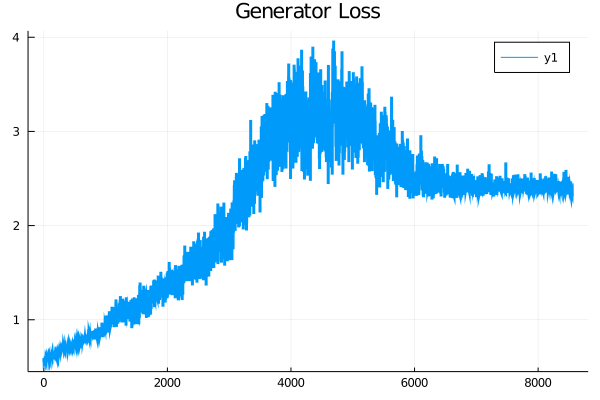

In [105]:
println("Generator loss")

println(gLoss_vals)
# for l in gLoss_values
#     println(l)
# end

plot(gLoss_vals, title = "Generator Loss", linewidth=3)

Discriminator loss
Any[1.5060608f0, 1.4629982f0, 1.4464738f0, 1.3803781f0, 1.4872863f0, 1.4069731f0, 1.4835253f0, 1.4243908f0, 1.4547646f0, 1.3117523f0, 1.4120232f0, 1.4425576f0, 1.3909632f0, 1.4009135f0, 1.3649338f0, 1.3749198f0, 1.3865821f0, 1.3093979f0, 1.3834264f0, 1.366777f0, 1.347456f0, 1.3316176f0, 1.4059484f0, 1.3227243f0, 1.3106749f0, 1.3162844f0, 1.317986f0, 1.3457184f0, 1.3560903f0, 1.3559405f0, 1.3407209f0, 1.3151907f0, 1.2988344f0, 1.3113413f0, 1.3484936f0, 1.3158991f0, 1.3234538f0, 1.3055203f0, 1.3185933f0, 1.2452074f0, 1.308263f0, 1.2988669f0, 1.2451435f0, 1.2777134f0, 1.2868756f0, 1.3379833f0, 1.30583f0, 1.3023266f0, 1.2578354f0, 1.245278f0, 1.3005514f0, 1.2272475f0, 1.2095162f0, 1.2878722f0, 1.3376286f0, 1.2466841f0, 1.2318647f0, 1.2050192f0, 1.1861556f0, 1.289559f0, 1.2228117f0, 1.2389466f0, 1.2099249f0, 1.1578947f0, 1.1926272f0, 1.2818906f0, 1.2355545f0, 1.1957643f0, 1.1990814f0, 1.129222f0, 1.1882274f0, 1.1500012f0, 1.1696713f0, 1.1973073f0, 1.1817104f0, 1.1739709f0

 0.35720205f0, 0.26520458f0, 0.6103498f0, 0.47562456f0, 0.3485548f0, 0.55847675f0, 0.38118574f0, 0.36692515f0, 0.32283798f0, 0.42144853f0, 0.42754096f0, 0.5355133f0, 0.32754183f0, 0.33897346f0, 0.30420834f0, 0.53115946f0, 0.5246199f0, 0.44783577f0, 0.35112932f0, 0.49857053f0, 0.6012336f0, 0.3449772f0, 0.3193095f0, 0.45630494f0, 0.36650708f0, 0.3339567f0, 0.5114244f0, 0.35046354f0, 0.41886297f0, 0.3809592f0, 0.4628161f0, 0.34662065f0, 0.41243815f0, 0.41124862f0, 0.49399695f0, 0.4498907f0, 0.43503857f0, 0.44063848f0, 0.44032383f0, 0.6105598f0, 0.4175908f0, 0.42932576f0, 0.3434992f0, 0.28582677f0, 0.50406885f0, 0.47676697f0, 0.4374649f0, 0.4631176f0, 0.42912903f0, 0.3769415f0, 0.31494117f0, 0.31608087f0, 0.42124075f0, 0.53411865f0, 0.43889967f0, 0.37324366f0, 0.38995367f0, 0.33905077f0, 0.55912817f0, 0.32562405f0, 0.36385363f0, 0.47074565f0, 0.396663f0, 0.40503806f0, 0.35651594f0, 0.42960224f0, 0.44728088f0, 0.27727962f0, 0.45837158f0, 0.60269755f0, 0.44210428f0, 0.4259469f0, 0.2775764f0,

 0.44723958f0, 0.43646175f0, 0.35141692f0, 0.40165147f0, 0.40923604f0, 0.27587917f0, 0.2647442f0, 0.42752853f0, 0.5959023f0, 0.26812094f0, 0.2991065f0, 0.5102669f0, 0.46435347f0, 0.35864052f0, 0.2059377f0, 0.3397761f0, 0.30684313f0, 0.44680142f0, 0.4961043f0, 0.3396156f0, 0.5497225f0, 0.42596292f0, 0.39426237f0, 0.60129017f0, 0.50882864f0, 0.24506307f0, 0.35610503f0, 0.3144044f0, 0.6151621f0, 0.2975882f0, 0.27733606f0, 0.58174264f0, 0.23070431f0, 0.31759614f0, 0.38217553f0, 0.35368922f0, 0.50437164f0, 0.5950219f0, 0.50884247f0, 0.3594752f0, 0.41587743f0, 0.664746f0, 0.297167f0, 0.41300353f0, 0.36996657f0, 0.3508374f0, 0.5118317f0, 0.5000535f0, 0.28576913f0, 0.2231824f0, 0.43591934f0, 0.30253518f0, 0.27040803f0, 0.19556579f0, 0.20859118f0, 0.30820537f0, 0.46255654f0, 0.20992407f0, 0.44395804f0, 0.3841937f0, 0.425531f0, 0.40616632f0, 0.19024523f0, 0.2384605f0, 0.32777217f0, 0.37124762f0, 0.20510268f0, 0.16801122f0, 0.3139065f0, 0.73348266f0, 0.44966644f0, 0.34105477f0, 0.59226334f0, 0.34

 0.31163377f0, 0.34751543f0, 0.45992595f0, 0.45447603f0, 0.26216263f0, 0.27595618f0, 0.34771192f0, 0.3302081f0, 0.34723312f0, 0.36409897f0, 0.31042948f0, 0.34086308f0, 0.31218427f0, 0.76546913f0, 0.5408286f0, 0.50929284f0, 0.33893675f0, 0.38860434f0, 0.29994246f0, 0.34886837f0, 0.3464989f0, 0.34685507f0, 0.35730553f0, 0.32994282f0, 0.35613614f0, 0.36285812f0, 0.33838192f0, 0.35116237f0, 0.36232027f0, 0.29195994f0, 0.31816465f0, 0.262955f0, 0.31048435f0, 0.30642658f0, 0.3600645f0, 0.31048116f0, 0.30164784f0, 0.3754539f0, 0.30573383f0, 0.34454238f0, 0.53463376f0, 0.340223f0, 0.3090392f0, 0.32295945f0, 0.31748417f0, 0.28955114f0, 0.30244514f0, 0.27638865f0, 0.374725f0, 0.6351432f0, 0.32581905f0, 0.29737854f0, 0.77520716f0, 0.32432854f0, 0.33715242f0, 0.26139584f0, 0.28689194f0, 0.3152238f0, 0.28965285f0, 0.34068036f0, 0.3498631f0, 0.32944632f0, 0.29285827f0, 0.27852437f0, 0.2772145f0, 0.33020324f0, 0.30444035f0, 0.35881957f0, 0.29145765f0, 0.29276353f0, 0.32721007f0, 0.29788688f0, 0.47416

, 0.34272462f0, 0.33585528f0, 0.33452165f0, 0.3264523f0, 0.342491f0, 0.3258991f0, 0.33148608f0, 0.323689f0, 0.33565974f0, 0.334258f0, 0.33419687f0, 0.32893074f0, 0.3355164f0, 0.3326494f0, 0.3418011f0, 0.33530134f0, 0.34116095f0, 0.32471454f0, 0.34099406f0, 0.34168696f0, 0.34146586f0, 0.34124982f0, 0.33120954f0, 0.3409846f0, 0.33088928f0, 0.33499742f0, 0.33579427f0, 0.3410588f0, 0.34047264f0, 0.33421385f0, 0.33413458f0, 0.32822317f0, 0.34085885f0, 0.33437768f0, 0.33486134f0, 0.33411962f0, 0.34409636f0, 0.34073758f0, 0.33404052f0, 0.32530925f0, 0.3349964f0, 0.32793498f0, 0.3339583f0, 0.34097713f0, 0.340712f0, 0.34048694f0, 0.33046478f0, 0.33492878f0, 0.34012443f0, 0.32451743f0, 0.3403949f0, 0.34001964f0, 0.3130612f0, 0.32432947f0, 0.33403486f0, 0.34088725f0, 0.33141345f0, 0.33385485f0, 0.3280477f0, 0.34005076f0, 0.34047055f0, 0.34028158f0, 0.33011943f0, 0.33474776f0, 0.33000702f0, 0.34003797f0, 0.3285141f0, 0.33955207f0, 0.3346526f0, 0.3243643f0, 0.33933678f0, 0.33402795f0, 0.33394122f0,

0.33310726f0, 0.3341673f0, 0.32805538f0, 0.3333164f0, 0.33215085f0, 0.3378927f0, 0.3377871f0, 0.33768278f0, 0.33476982f0, 0.33760872f0, 0.33754158f0, 0.33418864f0, 0.33756185f0, 0.33250254f0, 0.3375966f0, 0.33756334f0, 0.33750945f0, 0.3374527f0, 0.33439845f0, 0.32253167f0, 0.3340691f0, 0.33689347f0, 0.33779532f0, 0.3377029f0, 0.33761328f0, 0.33753505f0, 0.3319453f0, 0.3375613f0, 0.3375067f0, 0.3374462f0, 0.33738813f0, 0.33590773f0, 0.3374514f0, 0.337422f0, 0.3373683f0, 0.3373153f0, 0.33726507f0, 0.32788527f0, 0.33722568f0, 0.327592f0, 0.3371919f0, 0.33713442f0, 0.33707914f0, 0.3370313f0, 0.33501f0, 0.3370191f0, 0.33699042f0, 0.33695778f0, 0.3369258f0, 0.33494428f0, 0.33691674f0, 0.33534288f0, 0.33711496f0, 0.337105f0, 0.323131f0, 0.337245f0, 0.3372188f0, 0.3371684f0, 0.33291572f0, 0.33229265f0, 0.33728686f0, 0.33723003f0, 0.33716413f0, 0.33476663f0, 0.33713016f0, 0.33708262f0, 0.33703712f0, 0.33231264f0, 0.3356456f0, 0.33720422f0, 0.3371941f0, 0.33715788f0, 0.33711544f0, 0.33707327f0, 

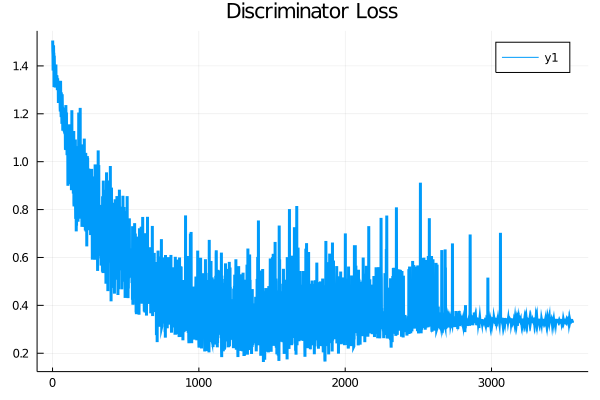

In [106]:
println("Discriminator loss")

println(dLoss_vals)
# for l in dLoss_values
#     println(l)
# end

plot(dLoss_vals, title = "Discriminator Loss", linewidth=3)

Mean gradients


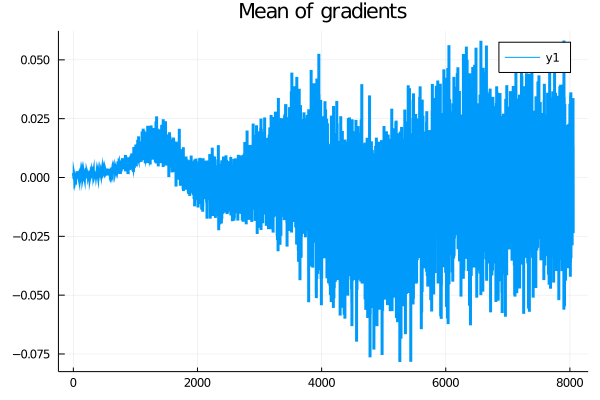

In [112]:
println("Mean gradients")

# println(mean_grads)
# for l in dLoss_values
#     println(l)
# end

plot(mean_grads, title = "Mean of gradients", linewidth=3)

In [108]:
println(epochs)

500


fake data: 0.9935004
real data: 0.9992755


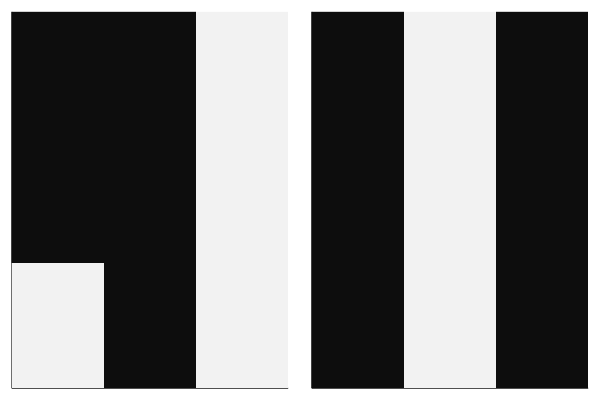

In [159]:
#Testing the Discriminator

d_iter = epochs

s = []

sample_fake = run_g(nbatch = 1)
d_fake = first(run_d_fake(sample_fake))
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
sample_real = data_train[index]
d_real = sample_real |> vec |> d |> first
println("real data: $d_real") #Should print a number close to 1

push!(s, reshape(sample_fake, n, n))
push!(s, sample_real)

plot([heatmap(ss, color=:grays, colorbar = false, ticks = false) for ss in s]...)

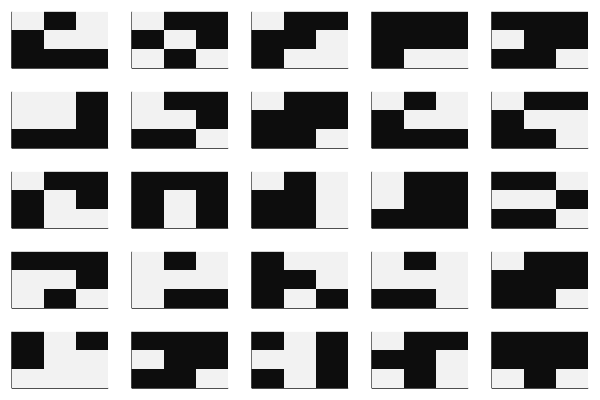

In [138]:
#Testing the Generator

g_iter = 1

dispatch!(g, g_params[g_iter]) #Reverts parameters of g to the g_iter th training epoch

nsamples = 25
samples = run_g(nbatch = nsamples)
plot([heatmap(reshape(samples[:, i], n, n), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)

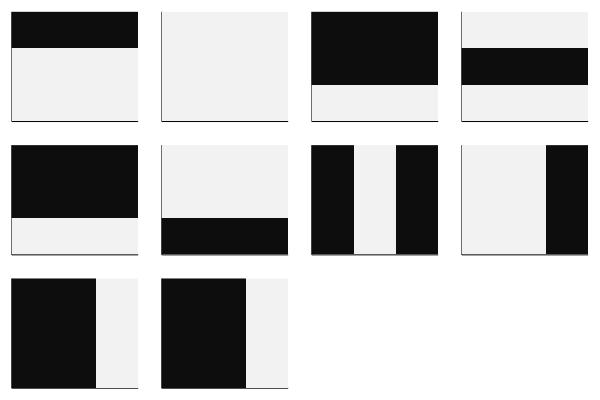

In [111]:
plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)